In [37]:
# from __future__ import division # uncomment this if using Python 2.7
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# plot inline rather than pop out
%matplotlib inline
# change the plot size, default is (6, 4) which is a little small
plt.rcParams['figure.figsize'] = (20, 10)

# Lab 4 - Kalman Filter

In the previous lab we learned how to perform basic signal filtering operations in the Fourier domain. In this lab we will review the basic concepts of Kalman filtering and we will apply it to a real-world biological signal.

## Quick recap from theory

In order to describe the Kalman Filter, we start with the following state transition model:


$$s_{k+1} = \Phi s_k + q_{k}$$


where:
- $s_{k+1}$ is the N-dimensional *state vector* and it contains a description of the varying quantities of the system at time $k+1$
- $\Phi$ is the is the $N \times N$-dimensional *state transition matrix* which is applied to the previous state;
- $q_k$ is the N-dimensional *process noise vector* which is assumed to be drawn from a zero mean $E[q_k]=0$ multivariate normal distribution with its $N \times N$-dimensional *covariance matrix* $Q = E[q_k q_k^T]$

We also consider the following linear measurement model:

$$
m_k = H s_k + r_k
$$

where:
- $m_k$ is the M-dimensional *measurements/observation vector*, *i.e.* the vector that contains the measures;
- $H$ is the $M \times N$-dimensional *observation matrix* which maps the true state space into the observed space;
- $r_k$ is the M-dimensional *observation noise* which is assumed to be zero mean $E[r_k]=0$ Gaussian white noise with covariance $R=E[r_k r_k^T]$.




Kalman Filter takes advantage of noisy sensor data and equations that describe the system evolution to determine the state of a system. We report here an extract of the <a href="https://en.wikipedia.org/wiki/Kalman_filter">Wikipedia page </a> of Kalman Filter.



*The Kalman filter deals effectively with the uncertainty due to noisy sensor data and to some extent also with random external factors. The Kalman filter produces an estimate of the state of the system as an average of the system's predicted state and of the new measurement using a weighted average. The purpose of the weights is that values with better (i.e., smaller) estimated uncertainty are "trusted" more. The weights are calculated from the covariance, a measure of the estimated uncertainty of the prediction of the system's state. The result of the weighted average is a new state estimate that lies between the predicted and measured state, and has a better estimated uncertainty than either alone. This process is repeated at every time step, with the new estimate and its covariance informing the prediction used in the following iteration. This means that the Kalman filter works recursively and requires only the last "best guess", rather than the entire history, of a system's state to calculate a new state.*

## Equations summary


**Kalman gain estimate**

- $K_{k} = P_{k}^-H^T\big(HP_{k}^-H^T + R\big)^{-1}$ $\leftarrow$ an estimate of the Kalman  *gain*.

We can now rewrite Kalman Filter equations splitting them in two parts: **Update** and **Project (prediction)**.

**Update step**

- $\hat{s}_{k}=\hat{s}_{k}^-+K_{k}\big(m_{k}-H\hat{s}_{k}^-\big)$ $\leftarrow$ an update of the state of the system ***after*** the acquisition of a new measure
- $P_{k}=(I-K_{k}H)P^-_{k}$  $\leftarrow$ an update of the error covariance matrix ***after*** the acquisition of a new measure

**Project/prediction step**
 - $\hat{s}^{-}_{k+1} = \Phi\hat{s}_k$ $\leftarrow$ a prediction of the state update at time $k+1$ ***before*** taking a new measure
 - $P^{-}_{k+1} = \Phi P_k\Phi^T + Q$ $\leftarrow$ a prediction of the error covariance matrix update at time $k+1$ ***before*** taking a new measure
 
 
Is it everything clear? Let's implement our Kalman Filter and try it on a synthetic signal

In [38]:
def naive_KF(m, P_pred, s_pred, Phi, H, Q, R):
    """Naive Kalman Filter implementation.
    
    Inputs:
    - m (M-dim float) the new measurement
    - P_pred (NxN-dim float array) error covariance prediction
    - s_pred (N-dim float array) state prediction
    - Phi (float array) state transition matrix
    - H (MxN-dim float array) measurement matrix  
    - Q (NxN-dim float array) process noise covariance
    - R (MxM-dim float) measurement noise variance
    
    Outputs:
    - s
    - P_pred
    - s_pred
    
    """
    
   ### complete here ###
    
    # Kalman gain
    K = P_pred @ (H.T * 1/np.float64((np.dot(np.dot(H,P_pred),H.T) +R)))
    #K = K[:,None]  

    #Update
    s = s_pred + ( K[:,None] * (m - H @ s_pred))
    P = (np.eye(len(s_pred)) - K[:,None] @ H[:,None].T) @ P_pred
    
    #prediction
    s_pred = np.dot(Phi, s)
    P_pred = (np.dot(np.dot(Phi,P),Phi.T)) + Q
    
    return s, P_pred, s_pred 

## Piecewise linear signal

Let's consider a time range from 0s to 1s. Sample the time range with $f_s = 1000$ Hz.  Build a piecewise linear signal such that:

$$
k \in [0,0.3[ \rightarrow f(k) = -2k+3
$$

$$
k \in [0.3,0.6[ \rightarrow f(k) = k+2.1
$$

$$
k \in [0.6,1] \rightarrow f(k) = -4k+5.1
$$

set $m(k) = f(k) + r$, with $\sigma_r = 0.01$



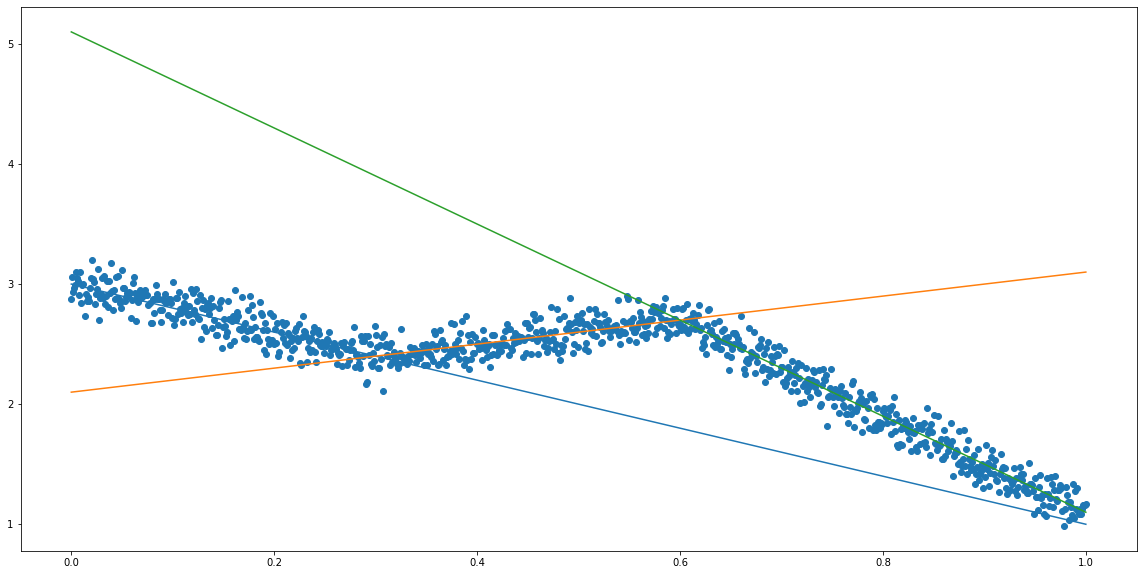

In [39]:
## complete here
def piece1(k) : return -2 * k + 3
def piece2(k) : return k  + 2.1
def piece3(k) : return -4 * k + 5.1


def f(k):
    if k >= 0 and k < 0.3:      return piece1(k)
    elif k >= 0.3 and k < 0.6:  return piece2(k)
    elif k >= 0.6 and k <= 1:   return piece3(k)
    else: return 0



# params
time_0 = 0
time_max = 1
freq = 1000
time = np.linspace(time_0,  time_max, freq)

sigma_r = 0.1
r = np.random.normal(0, sigma_r, len(time))

m = np.array([f(k) for k in time] + r  )
plt.plot(time,[piece1(k) for k in time])
plt.plot(time,[piece2(k) for k in time])
plt.plot(time,[piece3(k) for k in time])
plt.scatter(time, m)

In [40]:
# Initialization of s_pred and P_pred
### complete here ###
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])


In [41]:
# Pick Phi, H, Q, R
### complete here ###
Phi = np.array([[1, 1], [0, 1]])
H = np.array([1,0])
Q = np.array([[1/100000, 0], [0, 1/10000 ]])
R = sigma_r
print (Phi.shape,H.shape,Q.shape)

(2, 2) (2,) (2, 2)


In [42]:
# allocate func and der arrays

### complete here ###
func = np.zeros_like(time)
der = np.zeros_like(time)

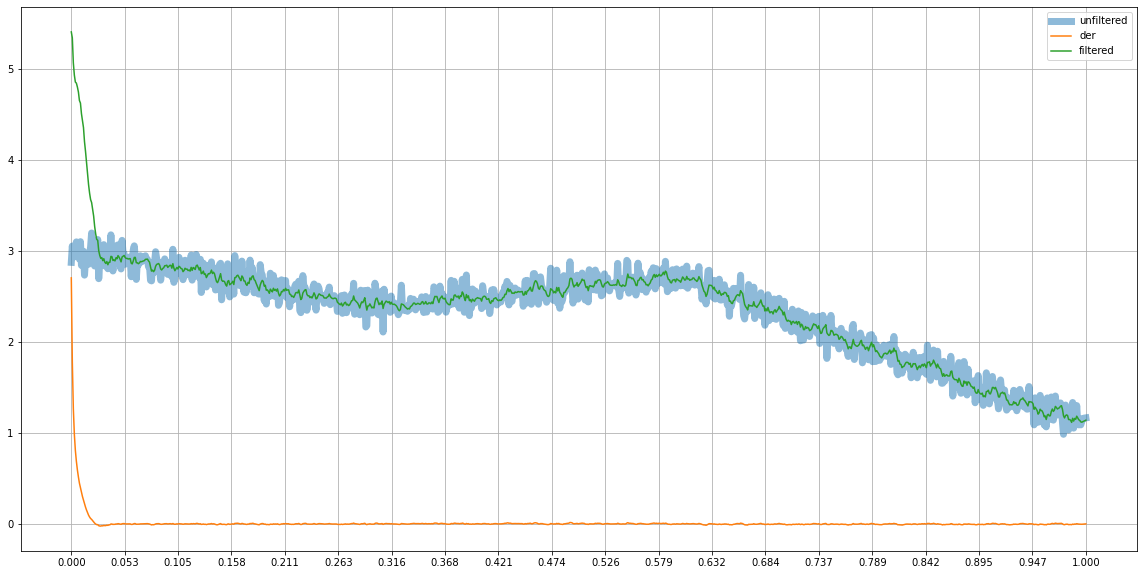

In [43]:
## call Kalman filter 

### complete here


for i, m_k in enumerate(m):
   s, P_pred_k , s_pred_k = naive_KF(m_k, P_pred,s_pred, Phi, H, Q, R)
   func[i] = s_pred_k[0]
   der[i] = s_pred_k[1]
   s_pred = s_pred_k.copy()
   P_pred = P_pred_k.copy()

fig, ax = plt.subplots(1)

ax.plot(time, m,alpha=0.5, label='unfiltered', linewidth=7.0)
ax.plot(time, der,alpha=1, label='der')
ax.plot(time, func,alpha=1, label='filtered')

ax.set_xticks(np.linspace(0,1,20))
ax.legend()
ax.grid()